### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2017 ###

# Driving Recommendations to Minimize Fuel given Traffic Lights Information #

#### Ainur Ainabekova (ainabekova@wisc.edu) and Subasree Venkatsubhramaniyen (venkatsubhra@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Objective Function](#2.A.-Objective-Function)
    1. [Fuel consumption when vehicle is in motion](#2.A.a.-Fuel-consumption-when-vehicle-is-in-motion)
    1. [Fuel consumption while idling](#2.A.b.-Fuel-consumption-while-idling)
    1. [Objective as a function of the absolute change in velocity](#2.A.c.-Objective-as-a-function-of-the-absolute-change-in-velocity)
    1. [Objective as a function of the absolute change in acceleration](#2.A.d.-Objective-as-a-function-of-the-absolute-change-in-acceleration)
  1. [Handling Traffic Lights](#2.B.-Handling-Traffic-Lights)
1. [Solution](#3.-Solution)
  1. [MILP model with linear objective](#3.A.-MILP-model-with-linear-objective)
    1. [Objective that considers 2.A.a and 2.A.b](#3.A.a.-Objective-that-considers-2.A.a-and-2.A.b)
    1. [Objective that considers 2.A.a , 2.A.b and 2.A.c](#3.A.b.-Objective-that-considers-2.A.a-,-2.A.b-and-2.A.c)
    1. [Objective that considers 2.A.a , 2.A.b , 2.A.c and 2.A.d](#3.A.c.-Objective-that-considers-2.A.a-,-2.A.b-,-2.A.c-and-2.A.d)
  1. [MIP model with quadratic objective ](#3.B.-MIP-model-with-quadratic-objective)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

This project aims to solve the problem of optimizing fuel consumption of the vehicle given the positions of traffic lights and their phase change timings. The model we have built gives recommendations to the vehicle in terms of its velocity and velocity changes at each second in order to minimize fuel for the whole trip without violating rules related to the traffic lights and speed limits on that route.

The idea of providing speed recommendations in order to minimize fuel popped up in our minds when we were in the Data Visualization class (CS765) where we saw visualization of traffic flow in San Francisco. We wanted to explore more about this visualization and that led to the Green Wave problem. [Green wave](https://en.wikipedia.org/wiki/Green_wave) is a phenomenon that takes place when a number of traffic lights are designed to coordinate continuous traffic flow where drivers have a chance to confront only green lights. This green wave idea recommends a speed on the route. This minimizes the wait time (assuming engine doesn't get turned off at the red light) of the vehicle and therefore reduces the fuel consumption. For example, United Parcel Service (UPS) trucks also try to reduce the fuel consumption rather than total time of the trip, and one part of their solution is to never take left turns. They discovered that this simple technique saves them 10 million gallons of fuel every year and they emit 20,000 tones less of carbon dioxide ["Why UPS never takes left"](http://theconversation.com/why-ups-drivers-dont-turn-left-and-you-probably-shouldnt-either-71432). This makes the problem interesting from two perspectives namely eco-friendly driving and cost saving which is not considered often as we do not account for all traffic lights along the route. 

![animation][GreenWave]

In our project we neither alter the timings of the traffic lights nor we give recommendation for the traffic light timings. We rather provide speed recommendations for a vehicle given the traffic light data in advance. 

There have been mutiple research studies that attempt to solve problem. M. Barth, et. al. ["Dynamic ECO-Driving"](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5973594&tag=1) suggest dynamic eco-driving velocity planning algorithm for arterial corridors that specifies acceleration and deceleration profile design and optimizes fuel consumption with respect to traffic lights. Some of their advices are driving smoothly, avoiding high speeds and low speeds, accelerating slowly. As a result they obtained 10% to 15% fuel economy. 

Another study that inspired us was the [Green Light Optimized Speed Advisory - GLOSA](http://personal.ee.surrey.ac.uk/Personal/kk00085/papers/KK_GLOSA_IWCMC_11.pdf). Authors of this paper formulated an algorithm to improve the fuel consumption and reduce the traffic congestion. Algorithm considers information from traffic lights that have special devices that broadcast messages to vehicles. Speed velocity decisions can only be made when vehicle is close enough to receive messages from traffic light. GLOSA-equipped cars can save up to 7% of the fuel consumption. 

Our idea of speed recommendations can be embedded to the navigation systems like Google Maps which are aware of the routes and therefore can accommodate the information of traffic lights. We also believe our idea can be a realistic recommendation to a self-driving car.   

Further in our project report, in the section 2-Mathematical model, we will explain data, variables, constraints and objective function in more detail, as well as we will explain techniques from optimization class that we have used in order to build the model. In section 2 we will pay more attention to how we tried to make our objective function linear instead of non-linear (using SOS2 constraint), and how we handled traffic lights (so that vehicle never violates the rules). In section 3 - Solution, we will consider several different models based on different types of objectives, that finally will lead us to the model that we concluded to work best for our problem. We will also show how different objectives relate to the speed of the vehicle. In section 4 - Results and Discussion, we will show plots that prove the fact that vehicle doesn't violate any of the traffic lights' rules and reaches the destination successfully. We will also show that our model is scalable and works well for any number of traffic lights, and moreover works for the scenario close to the real-world scenario. Section 4 also compares the fuel consumption of the vehicle which follows the speed recommendations given by our model and vehicle that is not aware of any traffic light information (current real-world driving). Finally, we will conclude with the section 5 where we will talk about future directions. 

[GreenWave]: https://upload.wikimedia.org/wikipedia/commons/f/f6/GreenWave.gif

## 2. Mathematical model ##

Our model is <b>Mixed Integer Linear Problem (MILP)</b>. Main decision variables namely velocity, acceleration, and position of the vehicle are modelled per second. All of them are continuous variables. There are a number of supporting variables for numerous logical constraints that are binary that make the model to be mixed integer in nature. 


#### Data parameters

- <b>T</b> - upper bound on the total time of the trip 
- <b>D</b> - destination's position, given assumption that initial position is 0
- <b>Light_pos</b> - an array of positions of lights 
- <b>t_r</b> and <b>t_g</b> - time until red and time until green for each traffic light. Each light can have its own phase of change of colors and we can specify what is the start color for each. 

#### Decision Variables 

- <b>x</b> - array of size T that denotes vehicle's position at each second
- <b>v</b> - array of size T that denotes vehicle's velocity at each second
- <b>a</b> - array of size T that denotes vehicle's acceleration at each second

#### Motion constraints 

- Velocity at each second should not exceed maximum speed limit.
- Acceleration at each second should not exceed maximum acceleration limit and should not go below minimum limit.
- Initial and final velocities are 0.  
- Vehicle doesn't move beyond the destination position. 
- $v[i+1] = v[i] + a[i]$ 
- $x[i+1] = x[i] + a[i]/2 + v[i]$ 

### 2.A. Objective Function 

<b>Objective function</b> minimizes fuel consumption by penalizing four things: 

- Fuel consumption when the vehicle is moving
- Fuel consumption when vehicle waits at the red light with engine on
- Absolute change in the velocity, i.e. L1-norm of acceleration
- Absolute change in the acceleration, i.e. jerk


#### 2.A.a. Fuel consumption when vehicle is in motion

   Below is a plot of fuel consumption with respect to velocity. We can see that in general there is a mid-range of optimal velocities that lead to efficiency of engines, whereas more fuel is consumed at low and high speeds (aerodynamic resistance). 

<img src = "http://github.com/subasreev/CS524_Project/blob/master/FuelVsSpeed.jpg?raw=true" width="700">

   We converted this to piecewise linear function to make our objective linear: 
  
$$
f(v)=
\begin{cases}
0.1*(-13/2*v+59) & 0 \le v\le 8\\
0.1*7 & 8 \lt v\le 15\\
0.1*(3/4*v-17/4) & v\gt 15\\
\end{cases}
$$
    where, a factor of 0.1 is multiplied in order to normalize the range of values with respect to different parts of the objective function. This way, none of the terms in the objective function would dominate the result.
    
<img src = "https://github.com/subasreev/CS524_Project/blob/master/PiecewiseFuel.png?raw=true" width = "600">
   
   This function should be used to count consumed fuel only when vehicle's engine is turned on, and vehicle has not yet reached the destination. After it reaches destination, we assume engine is turned off and fuel should not be counted according to this piecewise linear function. One of the ways we can handle this case is by creating a binary variable that will be 1 if the position of the vehicle is less than destination, and multiply it by the value of the piecewise linear function. But this would make the objective non-linear. Therefore, we modeled this piecewise function using SOS2 constraint. 
   
   For each segment of the piecewise function there is a binary variable (z_p) and a lambda associated with it. 

|             | v_endpoint  | f    | l   | g     |
| ------------|:-----------:| ----:|----:|------:|
| segment 1   | 8           |0.7   |8    |-13/2  |
| segment 2   | 8           |0.7   |7    |0      |
| segment 3   | 15          |0.7   |4    |3/4    |

   where (v, f) - (speed, fuel) end-point for a segment, l - segment length for x-axis, g - slope of the segment. 
    
   SOS2 constraints are designed to ensure that exactly one z_p=1, that is one segment is chosen, and corresponding consecutive lambdas are non-zero. This is true for each v[i]. 
    
   Each point on the function (v,f) follows these rules that we also have modeled: 
    
$$v =  \sum_{j=1}^m(z[j]*v\_endpoint[j] + sign( l[j] )*λ[j] )$$
$$fuel = \sum_{j=1}^m(z[j] * f[j] + sign( l[j] ) * g[j] * λ[j])$$

   where m is the number of segments in the piecewise function. 
   
#### 2.A.b. Fuel consumption while idling  

   Idling wastes fuel since you do not usually turn off engine at the red light. As the vehicle is accelerating from a dead stop, energy required for that is larger than from a moving velocity. 
   Idling time was computed based on how many seconds speed was equal to 0 and vehicle has not yet reached the destination. We have used binary variable z_7 for the case when velocity is 0, and binary variable z_8 for the case when position is less than the destination. Binary variable z_9 was used to encode the AND condition of these two cases. Finally, we sum the z_9 variable's values and multiply by the predefined value of fuel consumed per second whiile idling. 


#### 2.A.c. Objective as a function of the absolute change in velocity 

   We also need to minimize the L1-norm of the difference in velocity, i.e. acceleration. To do this we use epigraph technique to encode absolute values which allows us to make objective linear. This helps to achieve smooth driving which in turn reduces fuel consumption. 
    
#### 2.A.d. Objective as a function of the absolute change in acceleration 

   Similar to the section 2.2 we used epigraph technique to consider absolute change in the acceleration, i.e. jerk at each second during the trip. Rapid change in acceleration causes discomfort to the passengers as well as lowers gas mileage. 
    
    
### 2.B. Handling Traffic Lights 

Logical constraints with respect to traffic light (binary variables z_1, ..., z_6)

- case 1: when vehicle is very close to the traffic light and the light is green, vehicle is allowed to move, which means x position of the vehicle can go past traffic light. Very close to the traffic here means x position of the vehicle is in the range [traffic light position - maximum velocity, traffic light position], because this range is a maximum distance vehicle can cover in 1 second. We assume that in this case the vehicle can increase its speed or can continue with the same speed and manage to make it through the green light with no idling. 

- case 2: when vehicle is exactly at the position of the traffic light and the light is red, vehicle stops suddenly and hence spends some time idling until light turns green. This means we make the velocity of the vehicle to be 0, which can lead to the larger consumption of fuel. 

- case 3: when vehicle is very close to the traffic light and the light is red, vehicle can slow down but it is not allowed to go beyond traffic light's position while it is red. Therefore, all the subsequent x positions of the vehicle must be less than the traffic light's position until light goes green. 

In real-world, the traffic light cycle is Green-Yellow-Red-Green and hence, we always consider the presence of yellow light before red. So, we account for the yellow light duration as part of the red light. 
The array t_g a 2D array where each row represents the cycle of the particular traffic light, number of columns is T  and each value denotes the time remaining at a given second for the light to turn green. This means if the light is already green, then the value of t_g[k,:] for kth traffic light at that second is 0. Similarly, array t_r denotes the time remaining for the light to turn red.

Let’s consider a traffic light whose timings are as follows:
Green - Stays green for 15 seconds
Yellow + Red - Stays for 20 seconds 
Assume the traffic light starts at green.
Below are the examples of values of t_g and t_r with T=180 and timings mentioned above for green, red and yellow: 

    t_r: [14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,14,13,12,11,10]

    t_g: [0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,0,0,0,0,0]
    
 
Finally, below is the optimization model in the standard form: 

$$
\begin{aligned}
\underset{x,v,a, z\_p, z\_9 \in \mathbb{R^T}}{\text{minimize}}\qquad& \sum_{j=1}^3(z\_p_{t,j}*v\_func_j + l\_sign_j*g_j*\lambda_{i,j}) + |v| + \sum_{i=2}^T|a_i-a_{i-1}| + sum(z\_9)*idle\_fuel \\
\text{subject to:}\qquad& x_{t+1} = x_{t} + 0.5*a_t + v_t && t=1,\dots,T-1\\
& v_{t+1} = v_t + a_t && t=1,\dots,T-1\\
& x_1 = v_1 = v_T = 0\\
& x_T = destination\\
\end{aligned}
$$

The first part of the objective denotes the SOS model of piece-wise linear function that encodes speed vs fuel. The constraints corresponding to traffic lights involve many binary variables and hence not included in the above standard form.

## 3. Solution ##

We are using libraries such as JuMP, Gurobi and PyPlot. We decided to use Gurobi because it solves MILP.  

### 3.A. MILP model with linear objective 

#### 3.A.a. Objective that considers 2.A.a and 2.A.b

In this model we consider only fuel consumed as a function of velocity. 

In [2]:
# Data 
start_x = 0           # start position of the vehicle
destination = 800     # position of destination
idle_fuel = 0.1/3600  # gallons per second consumed (statistical data) when vehicle stops with engine on
max_v = 19            # maximum speed limit on the route
min_a = -5            # minimum acceleration, limit of the vehicle, m/s^2
max_a = 5             # maximum acceleration, limit of the vehicle, m/s^2
T = 180               # maximum time to reach destination, in seconds
  
# traffic lights data 
n_lights = 3                         # number of lights on the route
traf_pos = [300, 500, 700]           # positions of the traffic lights 
t_green_duration = [10, 25, 20]      # how long light stays green for traffic light i 
t_red_duration = [20, 24, 24]        # how long light stays yellow + red for traffic light i, yellow is before red
start_color = [0, 1, 0]              # with which color light cycle starts for traffic light i, [red, green,red]

#=
 Values necessary for SOS2 constraint. 
 Piecewise Linear Function to map velocity to fuel consumed at that velocity
    
    y1 = 0.1*(-13/2*v[i]+59)
    y2 = 0.1*7
    y3 = 0.1*(3/4*v[i]-17/4)

=#
v_end_point = [8, 8, 15]
v_func = [0.7, 0.7, 0.7]
l = [-8, 7, 4]
l_abs = abs(l)
l_sign = [-1, 1, 1]
g = [-13/20, 0, 3/40];

In [3]:
# Values for each traffic light at each second that define how long it remains red or green 
t_g = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns green for each jth second  
t_r = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns red for each jth second

# start_color = 0 means red, start_color = 1 means green 
# k - index of the traffic light
# This function helps to assign the start color to the traffic light k.
function init_lights(start_color,k)
    if start_color==0  # if red 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k]) # repetition cycle of red and green 
            if j<=(t_red_duration[k]-1)                     # first section of the cycle is red 
                t_g[k, i] = t_red_duration[k] - j           # number of second till green at ith second
                t_r[k, i] = 0                               # kth light is red, at ith second
            else
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
            end
        end
    else             # if green 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])  # repetition cycle of red and green 
            if j<=(t_green_duration[k]-1)                    # first section of the cycle is green
                t_g[k, i] = 0                                # kth light is green, at ith second
                t_r[k, i] = t_green_duration[k] - j          # number of second till red at ith second
            else
                t_g[k, i] = t_red_duration[k] - j + t_green_duration[k]
                t_r[k, i] = 0
            end
        end
    end
end

# Set the start color and cycle of the traffic lights 
for i=1:n_lights
    init_lights(start_color[i], i)
end

In [4]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))

########################################## Variables #########################################

@variable(m, x[1:T] >=0 )                 # position at time t
@variable(m, 0 <= v[1:T] <= max_v)        # velocity at time t
@variable(m, min_a <= a[1:T-1] <= max_a)  # acceleration at time t      
@variable(m, w[1:T-1])                    # epigraph variable for the abs val of difference in velocity
@variable(m, w_a[1:T-2])                  # epigraph variable for the abs val of difference in acceleration (jerk)

# Binary variables for logical constraints z[k,i], kth light and ith second

@variable(m, z_1[1:n_lights, 1:T], Bin)   # iff z_1=1 then x[i] >= traf_pos of light k
@variable(m, z_2[1:n_lights, 1:T], Bin)   # iff z_2=1 then x[i] <= traf_pos of light k
@variable(m, z_3[1:n_lights, 1:T], Bin)   # if z_1=1 and z_2=1 then z_3 = 1; i.e. x[i] == traf_pos of light k
@variable(m, z_4[1:n_lights, 1:T], Bin)   # if x[i]>= traf_pos[k]-max_v then z_4=1
@variable(m, z_5[1:n_lights, 1:T], Bin)   # if x[i]<= traf_pos[k] then z_5=1
@variable(m, z_6[1:n_lights, 1:T], Bin)   # if z_4=1 and z_5=1 then z_6=1

# Binary variables for the logical constraints on the position and velocity of vehicle
@variable(m, z_7[1:T], Bin)              # if v[i]<=0 then z_7 = 1
@variable(m, z_8[1:T], Bin)              # if x[i]<=destination then z_8 = 1
@variable(m, z_9[1:T], Bin)              # if x[i]<=destination (z_8=1) and v[i]<=0 (z_7=1) then z_9 = 1

# Variables for the SOS2 constraint
@variable(m, z_p[1:T,1:3], Bin)
@variable(m, lambda[1:T,1:3] >= 0)

########################################## Constraints #########################################

@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # v = v_initial + at 
@constraint(m, x[T] == destination)                                  # we need to reach destination 
@constraint(m, x[1] == start_x)                                      # we need to start at given pos
@constraint(m, v[1] == 0)                                            # start at rest 
@constraint(m, v[T] == 0)                                            # end at rest

# SOS2 constraints to ensure choosing two consecutive end points of segments in 
# piecewise linear function, v vs fuel 
for i in 1:T
    @constraint(m, lambda[i,1] <= l_abs[1]*z_p[i,1])
    @constraint(m, lambda[i,2] <= l_abs[2]*(z_p[i,2] + z_p[i,1]))
    @constraint(m, lambda[i,3] <= l_abs[3]*(z_p[i,2] + z_p[i,3]))
    @constraint(m, sum(lambda[i,:]) <= sum(l_abs))
end
@expression(m, obj_t[i in 1:T], sum(z_p[i,j]*v_func[j] + l_sign[j]*g[j]*lambda[i,j] for j=1:3))
@expression(m, v_value[i in 1:T], sum(z_p[i,j]*v_end_point[j] + l_sign[j]*lambda[i,j] for j=1:3))
for i in 1:T                                    
    @constraint(m, v_value[i] == v[i])
end 
                                                                 
for i=1:T-1
    # Epigraph constraint for abs value of acceleration 
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
    
    # Epigraph constraint for abs value of difference in acceleration
    if i <= T-2
        @constraint(m, w_a[i] >= a[i+1]-a[i])
        @constraint(m, -w_a[i] <= a[i+1]-a[i])
    end
end

# Constraints to check whether vehicle should stop or move when it's close to the traffic light
for k = 1:n_lights
    for i=1:T
        
        # constraints for checking if x[i] == traf_pos[k] 
        @constraint(m, x[i]- traf_pos[k] <= destination*2*z_1[k, i] - (1-z_1[k, i])) 
        @constraint(m, x[i] - traf_pos[k] >= -traf_pos[k]*(1-z_1[k, i]))
        @constraint(m, x[i]- traf_pos[k] >= -traf_pos[k]*z_2[k, i] + (1-z_2[k, i]))
        @constraint(m, x[i]- traf_pos[k] <= destination*2*(1-z_2[k, i])) 
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 <= 2*z_3[k, i] - (1-z_3[k, i]))
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 >= -2*(1-z_3[k, i]))
                                
        # constraints for x[i] being close to traf_pos[k]
        @constraint(m, x[i] - (traf_pos[k]-max_v) <= destination*2*z_4[k, i] - 0.1*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]-max_v) >= -(traf_pos[k]-max_v)*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) >= -(traf_pos[k])*z_5[k, i] + 0.1(1-z_5[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) <= destination*2*(1-z_5[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 <= 2*z_6[k, i] - (1-z_6[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 >= -2*(1-z_6[k, i]))

        # enters this loop if light is red, t_g is positive 
        for j=i:i+t_g[k, i]
            if j<=T
                # if z_6=1 then x[i+1] ... x[i+t_g[i]] <= traf_pos[k] 
                # if it is red color, and you are close to the traf_pos[k], don't cross red light until green  
                @constraint(m, x[j]-(traf_pos[k]) <= 2*(destination)*(1-z_6[k, i])) 
                # if z_3=1 then v[j] = 0, last speed =0 when stops
                # if it is red and you are exactly at traf_pos[k], stop immediately 
                @constraint(m, v[j] <= max_v*(1-z_3[k, i]))                
            end
        end
    end
end

for i=1:T
                            
    # z_7[i] = 1, if v[i]=0, ignore first and last as they are defined to be 0
    if i>=2 && i <= T-1
        @constraint(m, v[i] >= -0.1*z_7[i]+(1-z_7[i]))
        @constraint(m, v[i] <= max_v*(1-z_7[i]))
    end
                            
    # this constraint is necessary to check whether x[i] is less than destination                
    @constraint(m, x[i] - (destination-0.01) >= -(destination-0.01)*z_8[i] + 0.01(1-z_8[i])) 
    @constraint(m, x[i] - (destination-0.01) <= destination*2*(1-z_8[i]))  # if z_8=1 then x<= dest-0.01
    
    # if x[i] >= destination, means our velocity is 0, then do not count fuel after that point  
    # else use the piecewise linear function defined for velocity vs fuel
    @constraint(m, sum(z_p[i,:]) <= z_8[i])         # if z_8==0 then sum(z_p)<=0
    @constraint(m, sum(z_p[i,:]) >= z_8[i])         # if z_8==0 then sum(z_p)>=0
    @constraint(m, sum(z_p[i,:])-1 >= -1(1-z_8[i])) # if z_8==1 then sum(z_p)>=1
    @constraint(m, sum(z_p[i,:])-1 <= -1(1-z_8[i])) # if z_8==1 then sum(z_p)<=1   
                            
    # count the number of times speed is 0 only when x[i]<destination to count idling time 
    @constraint(m, z_7[i] + z_8[i] - 2 <= 2*z_9[i] - (1-z_9[i]))  
    @constraint(m, z_7[i] + z_8[i] - 2 >= -2*(1-z_9[i]))
end

In [6]:
########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)

println("Objective value = ", getobjectivevalue(m))
println("Fuel consumed = ", getobjectivevalue(m))

Objective value = 61.86249999999998
Fuel consumed = 61.86249999999998


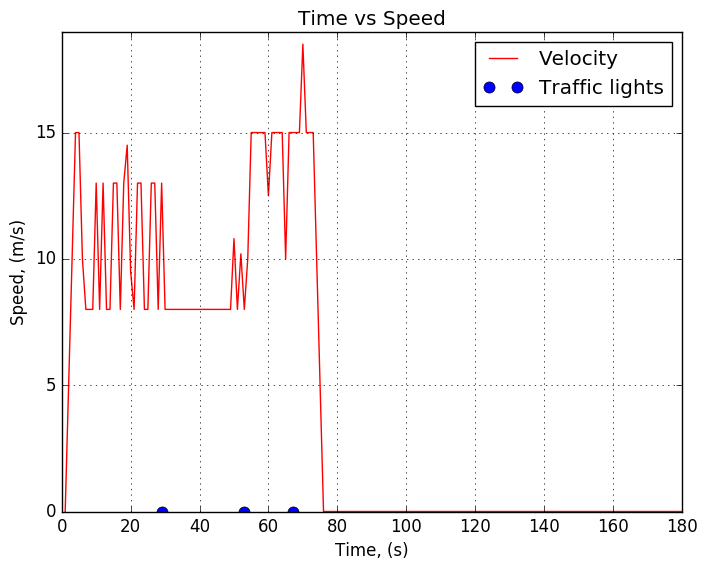

In [7]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend();

As we can see from this graph, driving isn't smooth even though fuel consumption is minimized. Therefore, we may need to consider penalizing rapid change in velocity. 

#### 3.A.b. Objective that considers 2.A.a , 2.A.b and 2.A.c

In this model we consider the L1-norm of the acceleration or change in velocity in addition to previous model. 

In [8]:
########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(w) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)
aopt = getvalue(a)

println("Objective value = ", getobjectivevalue(m))
println("Fuel consumed = ", sum(getvalue(obj_t)) + sum(getvalue(z_9))*idle_fuel)

Objective value = 85.2849056603761
Fuel consumed = 63.699999999999974


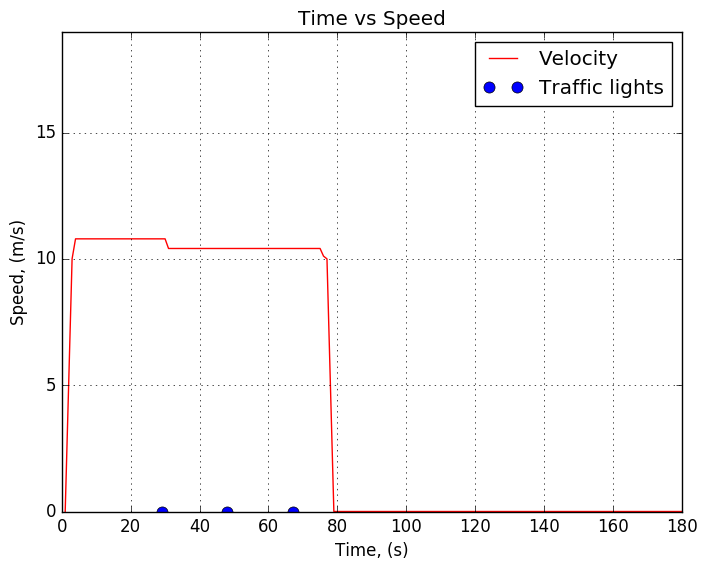

In [9]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend();

As we can see from the graph model doesn't recommend rapid changes in velocity. But let's take a look at the change in acceleration at each second for this model. 

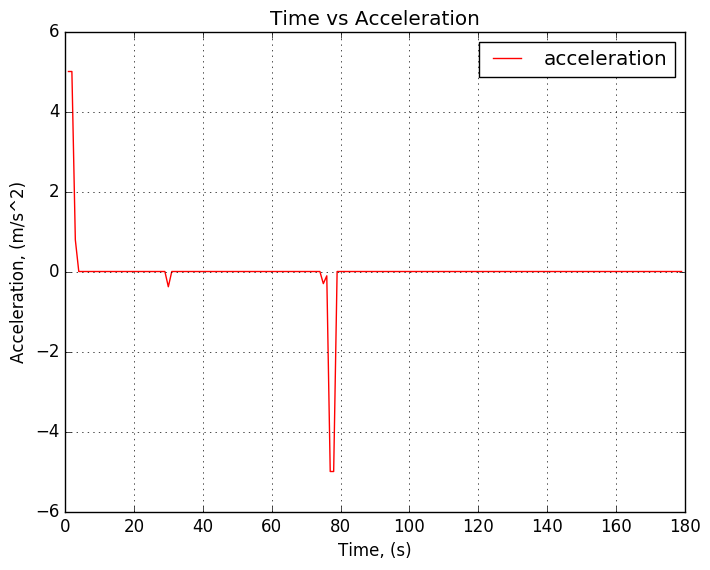

In [10]:
plot(t[1:T-1], aopt, label="acceleration", "r")
xlabel("Time, (s)")
ylabel("Acceleration, (m/s^2)")
title("Time vs Acceleration")
grid("on")
legend();

#### 3.A.c. Objective that considers 2.A.a , 2.A.b , 2.A.c and 2.A.d

Here we penalize the change in acceleration to account for minimum jerk. 

In [11]:
########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize absolute change in acceleration at each second
# 4) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(w) + sum(w_a) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)
aopt = getvalue(a)

println("Objective value = ", getobjectivevalue(m))
println("Fuel consumed = ", sum(getvalue(obj_t)) + sum(getvalue(z_9))*idle_fuel)

Objective value = 99.26416699311477
Fuel consumed = 64.99999999999997


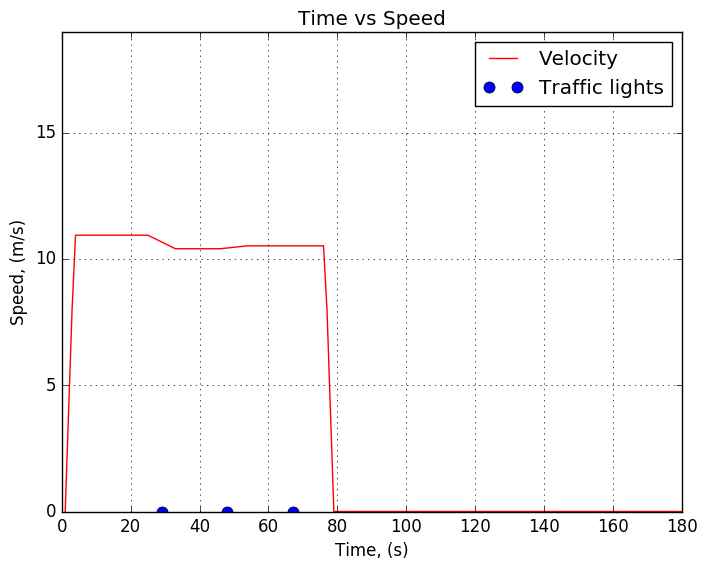

In [12]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend();

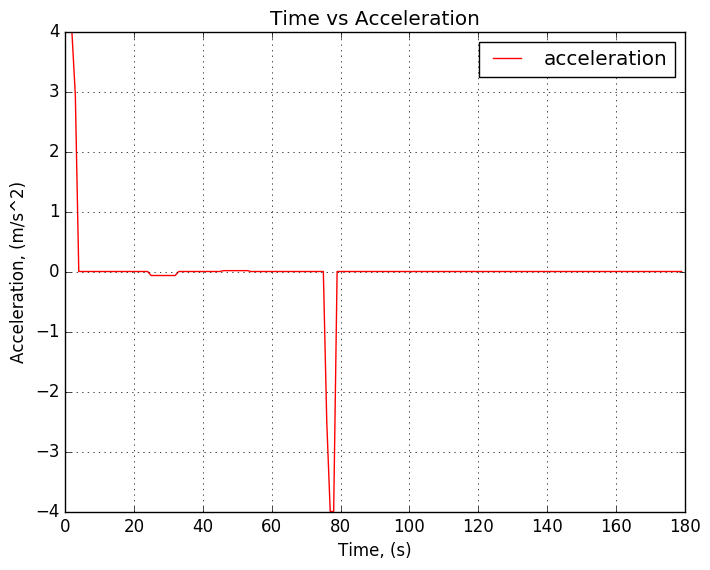

In [13]:
plot(t[1:T-1], aopt, label="acceleration", "r")
xlabel("Time, (s)")
ylabel("Acceleration, (m/s^2)")
title("Time vs Acceleration")
grid("on")
legend();

We see that adding L1-norm for the change in acceleration helped us a little bit by further smoothing the motion of the vehicle, for example approximately at t=25s.

### 3.B. MIP model with quadratic objective

In this model we would like to experiment with penalizing more for the changes in velocity and acceleration by using L2-norm for both. 

In [14]:
########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize absolute change in acceleration at each second
# 4) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(a.^2) + sum(w_a.^2) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)
aopt = getvalue(a)

println("Objective value = ", getobjectivevalue(m))
println("Fuel consumed = ", sum(getvalue(obj_t)) + sum(getvalue(z_9))*idle_fuel)

Objective value = 112.66854582991452
Fuel consumed = 81.88849232764761


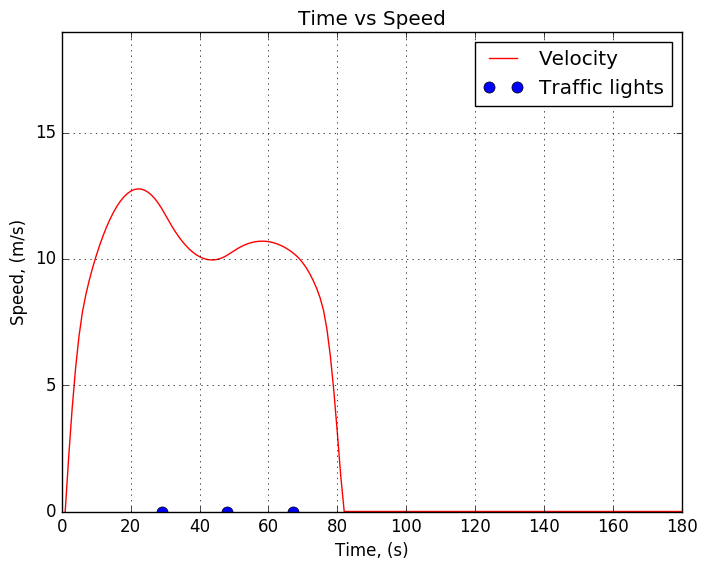

In [16]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend();

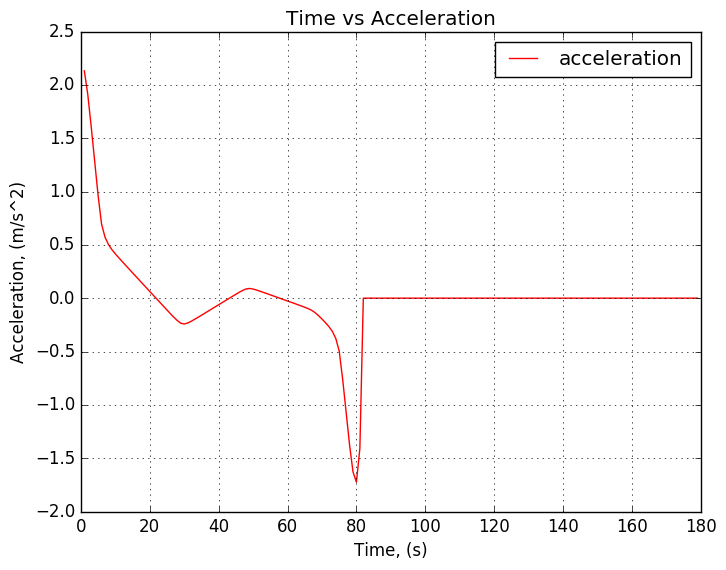

In [17]:
plot(t[1:T-1], aopt, label="acceleration", "r")
xlabel("Time, (s)")
ylabel("Acceleration, (m/s^2)")
title("Time vs Acceleration")
grid("on")
legend();

Both graphs for speed vs time and acceleration vs time are smoothened because that's the nature of L2-norm. But this model isn't realistic for real-world driving as it is difficult to make minor changes in velocity at each second. 

## 4. Results and discussion ##

We think that model 3.A.c is more realistic and considers all of the points we have described in the mathematical model section, i.e. L1-norm for the change in velocity and acceleration, fuel as a function of velocity and idling fuel. Therefore, further we are choosing model 3.A.c to show the rest of the results. 

In [18]:
########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize absolute change in acceleration at each second
# 4) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(w) + sum(w_a) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)
aopt = getvalue(a)

println("Objective value = ", getobjectivevalue(m))
println("Fuel consumed = ", sum(getvalue(obj_t)) + sum(getvalue(z_9))*idle_fuel)

Objective value = 99.26416699311498
Fuel consumed = 64.99999999999997


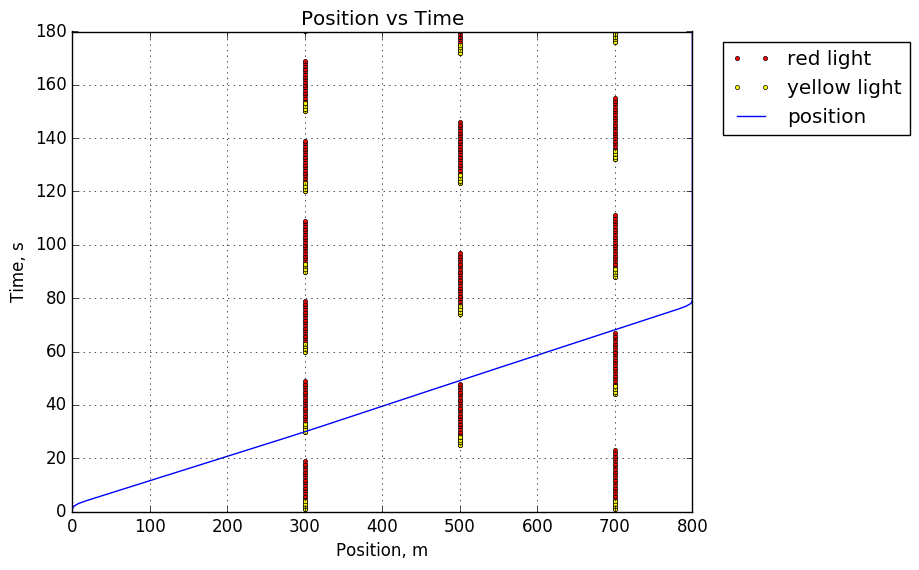

In [20]:
# Plot of Position vs Time (includes waiting time's position)
xlim(0,destination+100)

t_lights = zeros(n_lights, T)
t_yellow = zeros(n_lights, T)

for k=1:n_lights
    count = 0
    for i=1:T
        if t_r[k,i]==0
            if count < 4
                t_yellow[k,i] = i
            end
            count = count + 1
            t_lights[k,i] = i
        else # green 
            count = 0
        end
    end
end

traf_pos_x = zeros(n_lights, T)
for k=1:n_lights
    for i in 1:T
        traf_pos_x[k,i] = traf_pos[k]
    end
end
ctr1 = 0
ctr2 = 0
for k=1:n_lights
    for i=1:T
        if t_lights[k,i]>0
            if ctr1 == 0
                plot(traf_pos_x[k,i], t_lights[k,i], "ro", markersize = "3", label="red light")
            else
                plot(traf_pos_x[k,i], t_lights[k,i], "ro", markersize = "3")
            end
            ctr1 = ctr1 + 1
        end
    end
    for i=1:T
        if t_yellow[k,i]>0
            if ctr2 == 0
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", markersize = "3", linestyle="None", 
                    label="yellow light")
            else
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", markersize = "3", linestyle="None") 
            end
            ctr2 = ctr2 + 1
        end
    end
end
plot(xopt,t, label = "position")
ylim(0, T)
xlim(0, destination)
grid("on")
xlabel("Position, m")
ylabel("Time, s")
title("Position vs Time")
legend(loc = 9, bbox_to_anchor=(1.2, 1));

The blue line is the position of the vehicle over time, and as we can see it always passes the traffic light without violating rules, i.e. when the light is green. Sometimes vehicle moves past the signal when it is yellow, as it could be the edge of transition between green and yellow. In real life scenario cars usually can do that too. 

It is interesting to note that even if the cycles of the traffic lights aren't the same the vehicle still manages to meet the green lights. Our model tries to avoid idling at the red lights since it is the most expensive decision. However, if two lights are very close to each other (less than 30 meters) and green signal duration is as low as 1 second, then our model makes the vehicle stop and wait at red light. In a real world though we won't have these kinds of conditions, therefore, we can conclude that our original solution always causes **Green Wave phenomenon**. 

Below are the plots for the case when vehicle stops at red light. 

<img src = "https://github.com/subasreev/CS524_Project/blob/master/Stopping_v.png?raw=true" width = "600">

<img src = "https://github.com/subasreev/CS524_Project/blob/master/Stopping_x.png?raw=true" width = "600">

Our model works for any number of lights and is scalable as long as realistic numbers for the destination and total time of the trip are given to the model. 

We considered the route from Computer Science building to Hilldale Mall in Madison, WI. According to Google Maps distance between them is 4200m, and it takes approximately 4 minutes to reach the destination. According to the statistics taken from [Traffic Light Policy](http://epg.modot.mo.gov/index.php?title=940.6_Traffic_Signal_Spacing) the average distance between two traffic lights is about 400m. Based on the above information there are approximately 10 lights between CS building and Hilldale Mall. Below are the results for this scenario.  

<img src = "https://github.com/subasreev/CS524_Project/blob/master/ten_lights_4200m.PNG?raw=true", width = "600">

<img src = "https://github.com/subasreev/CS524_Project/blob/master/ten_lights_4200m_light.PNG?raw=true", width = "700">

Our model meets all the 10 green lights and never stops till it reaches the destination, which never probably takes place in a real-world. 

We would like to compare the optimized driving model with a real world driving and the difference in fuel. By real world driving we mean case when driver uses constant velocity constrained by the speed limit, might decelerate right before the red light. Below graph demonstrates the case where driver decelerates a little near signal 1 and passes it, but needs to stop and wait for 6 seconds in front of light 2. Driver uses constant speed equal to 15m/s for the most part of the trip. Given destination is at 700m, our model consumes 59.77742282838981 gallons of fuel whereas in real world driving it consumes ~70 gallons.  

<img src = "https://github.com/subasreev/CS524_Project/blob/master/Real_world_driving.png?raw=true" width = "600">

If we saved 11 gallons of fuel per 700m and for example an average distance travelled in a day by usual person is 78857.9 meters (49 miles per day), then that person saves ~1239 gallons per day. So, we think that model will be useful for UPS trucks. 

## 5. Conclusion ##

The model that we built to solve the minimization of fuel problem given information about traffic lights apparently solves the Green Wave problem, i.e. never makes the vehicle stop at the traffic light, because decelerating till speed 0 and accelerating again from rest spends too much fuel. Also, one can observe from the above graphs that the vehicle does not use the entire time (T) allotted and finishes the trip in accordance with the optimal velocities chosen. 

This model considers the information about all traffic lights together to choose optimal velocity and acceleration profiles. Another way to model this problem could be to consider one light at a time and make decisions about velocity based on that. 

However, this model doesn't consider an interesting case when driver takes his foot from the gas pedal and the vehicle eventually stops due to resistance, costing no fuel. This could be an extension to the project in the future. Also, this model doesn't include information about the traffic/congestion on the road which might also constrain the speed of the vehicle. 

Push-buttons on the traffic lights have not been taken into account since we assume that light timings are predetermined. 